<a href="https://colab.research.google.com/github/Joboreh97/TinyML_Projects/blob/main/TinyML_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ds-kiel/TinyML-Labs/blob/WS24-25/Lab2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/ds-kiel/TinyML-Labs/blob/WS24-25/Lab2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/ds-kiel/TinyML-Labs/WS24-25/Lab2.ipynb" download><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Quantization and On-Device Execution (Lab 2 & 3)

In the first lab you looked at the first part of the pipeline from data to executing models on low-power devices. You explored how to preprocess data and train neural networks with Edge Impulse. In this lab we continue the pipeline and you will explore how to [convert](https://ai.google.dev/edge/litert/models/convert_tf) a model to a [LiteRT](https://ai.google.dev/edge/litert) model, how to [quantize](https://ai.google.dev/edge/litert/models/post_training_integer_quant) [a model](https://www.tensorflow.org/model_optimization/guide/quantization/post_training), how to use [quantization-aware training](https://www.tensorflow.org/model_optimization/guide/quantization/training) and finally how to deploy the model and use the model with a microcontroller. **Come back to these documents in case you get stuck**.

You will explore the full pipeline from data to device using Tensorflow. You will train a model and convert, deploy, and execute it on a microcontroller, specifically the [Arduino Nano 33 BLE Sense](https://store.arduino.cc/products/arduino-tiny-machine-learning-kit).

This file is for both labs 2 and 3. Lab 2 is about generating a model in TF and quanizizing it. Lab 3 is then about the deployment.

## Environment

The instructions for this lab come as a [Jupyter Notebook](https://jupyter.org/). You can run it locally in your own Python environment, but we recommend you to use [Google Colab](https://colab.research.google.com) to save your compute ressources, have an instantly working python environment, and allow for easy collaboration. If your decide to use your local computer, take a look at Python virtual environments to avoid messing with your usual Python environment.

## What do you need to hand in?

Please complete the tasks by (a) completing the coding tasks and (b) answer the questions (please write a few lines directly in the notebook after the **Answer:** element). Thus, this Jupyter Notebook is intended as a document that you use both for working on the lab as well as for answering the questions. Once completed with lab 2 (or lab 3) let the teacher know. Be ready to demonstrate your results and show your code & answers to the tasks.

# Lab 2: Quantization

## Setup

In [1]:
# If you have not done so already, install the following dependencies (if you are in a local envoronment, you might need to install some more)
!python -m pip install tensorflow>=2.3 matplotlib seaborn cbor2

### Imports

In [2]:
import numpy as np
import pandas as pd
import os
import cbor2

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#import edgeimpulse as ei

import matplotlib.pyplot as plt
import seaborn as sns

#disable this if you are not using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Helper Functions

In [3]:
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'Model {model_name}')
    fig.set_figwidth(15)

    ax1.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'])
    ax1.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['training', 'validation'], loc='best')

    ax2.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
    ax2.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['training', 'validation'], loc='best')
    plt.show()

## Edge Impulse Dataset

### Prepare the data

---
**Task 1:** Navigate to the *Data acquisition* page in your Edge Impulse project of lab 1 and export the data.

**Task 2:** Import the data with the code below.

---

In [4]:
labels = ['idle', 'circle', 'left-right', 'up-down'] # Change this to your labels if needed
num_classes = len(labels)

data_path = '/content/drive/MyDrive/lab1_redo-export' # Change this to the path of your downloaded folder

# Select the window size and stride you used in Edge Impulse
window_size_ms = 2000
window_stride_ms = 100


# Function to create windows from the data
def create_windows(df, window_size_ms, window_stride_ms, label):
    window_size = int(window_size_ms / 10)
    window_stride = int(window_stride_ms / 10)
    windows = []
    windows_labels = []
    for i in range(0, len(df) - window_size, window_stride):
        windows.append(df.iloc[i:i+window_size].values)
        windows_labels.append(label)
    return np.array(windows),windows_labels

# Load the data from the files
def load_data(data_path, folder):
    data = np.zeros((1, int(window_size_ms / 10), 3))
    data_labels = []

    full_folder_path = os.path.join(data_path, folder)

    for file in os.listdir(full_folder_path):
        if file.endswith('.cbor'):
            label = file.split('.')[0].strip()
            file_path = os.path.join(full_folder_path, file)

            with open(file_path, 'rb') as f_obj:
                data_file = cbor2.load(f_obj)
                df = pd.DataFrame(
                    data_file['payload']['values'],
                    columns=[item['name'] for item in data_file['payload']['sensors']]
                )
                df = df.drop(columns=['gyrX', 'gyrY', 'gyrZ', 'magX', 'magY', 'magZ'])

                window_data, window_labels = create_windows(df, window_size_ms, window_stride_ms, labels.index(label))
                data = np.concatenate((data, window_data), axis=0)
                data_labels += window_labels

    data = np.delete(data, 0, axis=0)
    return data, data_labels


x_train, y_train = load_data(data_path, 'training')
x_test, y_test = load_data(data_path, 'testing')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Exception ignored in: <function _xla_gc_callback at 0x797e94055620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


---
**Task 3 (optional):** Perform scaling on your data if you like to. *Please note: You have to do the same scaling later in your Arduino program.*

---

In [5]:
# perform your scaling here

### Build the model

---
**Task 4:** Add your best model from lab 1, that uses a raw data preprocessing block.

---

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_model(summary=True):
    model = Sequential()

    # Input shape should match your data: (200, 3)
    model.add(Conv1D(8, kernel_size=3, padding='same', activation='relu',
                     input_shape=(200, 3)))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Conv1D(8, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Flatten())  # Flatten before Dense layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    if summary:
        model.summary()

    return model


In [9]:
model = build_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 200, 8)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 8)         │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,884 (7.36 KB)

 Trainable params: 1,884 (7.36 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

So far, you manually explored how many epochs are necessary to successfully train the model. However, Tensorflow gives you an option to automate this called [early stopping](https://keras.io/api/callbacks/early_stopping/). See also [here](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) and [here](https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd).

---
**Task 7:** Use an early stopping callback in your fitting function to find the optimal number of epochs. Use reasonable configurations. How many epochs does it train for?

**Answer:** ...

---21 epochs

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.2514 - loss: 1.7246 - val_accuracy: 0.2295 - val_loss: 1.4719
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4583 - loss: 1.1480 - val_accuracy: 0.2156 - val_loss: 1.4543
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7083 - loss: 0.8452 - val_accuracy: 0.3094 - val_loss: 1.3029
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7792 - loss: 0.6198 - val_accuracy: 0.4731 - val_loss: 1.0158
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8427 - loss: 0.4903 - val_accuracy: 0.6707 - val_loss: 0.8244
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8864 - loss: 0.3766 - val_accuracy: 0.8782 - val_loss: 0.5312
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9132 - loss: 0.2949 - val_accuracy: 0.9361 - val_loss: 0.3612
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9290 - loss: 0.2438 - val_accuracy: 0.9541 - 

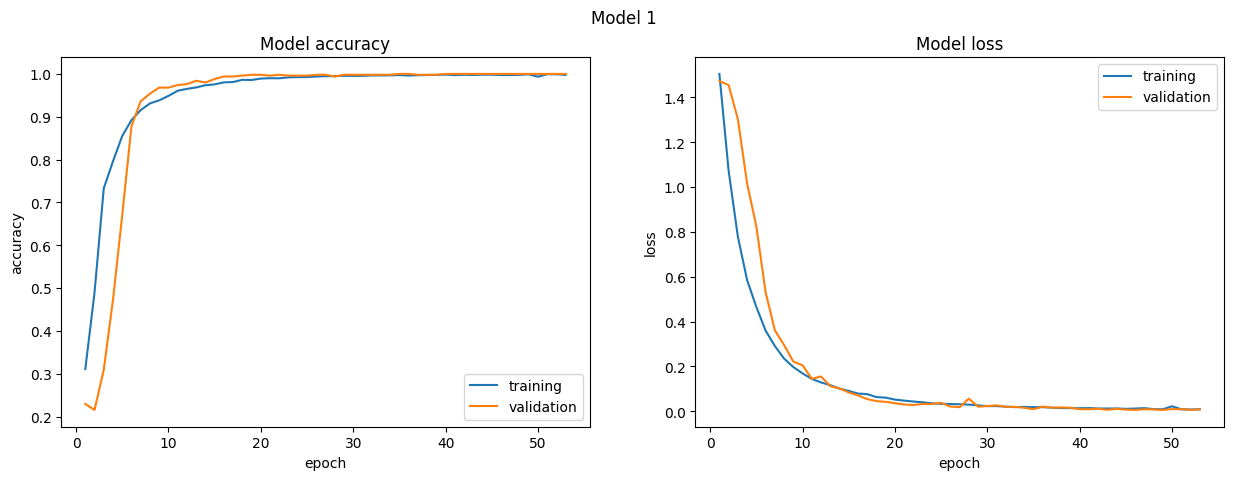

In [10]:
early_stopping_cb = EarlyStopping(
    monitor='val_loss',     # what to monitor
    patience=10,            # how many epochs with no improvement before stopping
    min_delta=0.001,        # minimum change to be considered improvement
    mode='min' ,           # 'min' since we want to minimize val_loss
)

num_epochs = 200
history = model.fit(x_train, y_train, batch_size=128, epochs=num_epochs, validation_split=0.1, callbacks=[early_stopping_cb])
plot_training_history(history, 1)

### Evaluate the Model



46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8196 - loss: 14.8552
Test loss: 11.592256546020508
Test accuracy: 0.8645116686820984
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


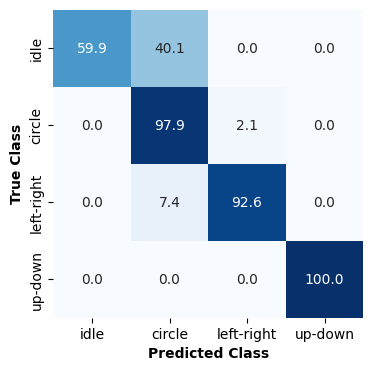

In [12]:
score_model = model.evaluate(x_test, y_test) #, verbose=0)
print("Test loss:", score_model[0])
print("Test accuracy:", score_model[1])

cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(x_test),axis=1))
# print(cm)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm = pd.DataFrame(cm, index = labels,
                  columns = labels)

plt.figure(figsize = (4,4))
ax = sns.heatmap(cm*100,
           annot=True,
           fmt='.1f',
           cmap="Blues",
           cbar=False,
              )
ax.set_ylabel("True Class", fontdict= {'fontweight':'bold'})
ax.set_xlabel("Predicted Class", fontdict= {'fontweight':'bold'})

plt.show()

---
**Task 8:** How does the accuracy of your model compare to the accuracy you achieved with Edge Impulse?

**Answer:** ...
The accuracy has similar value , 99%

---

### Save Model

To come back to a model to continue working on it, it might be useful to save it. We can use the `model.save()` [Function](https://www.tensorflow.org/guide/keras/serialization_and_saving) that exports a TensorFlow model object to SavedModel format.

If you use Google Colab, you can find the saved model as a `.keras`-file on the left under `Files/`.

In [13]:
export_path = 'saved_model.keras'
model.save(export_path)

### Model Quantization

Your microcontroller cannot use the Tensoflow model directly. Instead there is [LiteRT](https://ai.google.dev/edge/litert) for deploying models on mobile and edge devices.

---
**Task 9:** Load your model and convert it with LiteRT and save the model to a `.tflite`-file. (HINT: Check out [this](https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/examples/hello_world) *Hello World* example and [these instructions](https://ai.google.dev/edge/litert/models/convert_tf).)

**Task 10:** Create a second LiteRT conversion that uses [optimizations](https://ai.google.dev/edge/api/tflite/python/tf/lite/Optimize) and enforce integer-only weights.
(Maybe a helpful [resource](https://ai.google.dev/edge/litert/models/post_training_quantization).)

**Task 11:** Evaluate all converted models and compare them to the Tensorflow model they are based on regarding profiled memory usage and accuracy. Use plots.

**Task 12:** Explain your findings from the previous task. Why is there such a difference in performance and in memory usage?

**Answer:** ...
**Explanation of Results:**

- **Accuracy:** The original TensorFlow and float32 TFLite models have nearly identical accuracy. The INT8 quantized model may show a slight drop in accuracy depending on the complexity of the model and the quality of the representative dataset.
  
- **Memory Usage:** The quantized INT8 model is significantly smaller than the float32 model. This is because it uses 8-bit integers instead of 32-bit floats, reducing model size by ~75%.

- **Performance Differences:** Quantization reduces numerical precision, which may slightly affect performance. However, for many applications (especially embedded systems or edge ML), the trade-off is worth it due to the drastic reduction in size and improvement in inference speed on supported hardware.

- **Use Case Suitability:** The INT8 model is best suited for deployment on microcontrollers or mobile devices, where memory and compute power are limited.


---

In [26]:
# ADD YOUR MODEL CONVERSIONS HERE


import tensorflow as tf

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmprgujpdyp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133584766329552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133584766327440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133584766332624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133584766326672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133584766334736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133584766335504: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [27]:
# Save the converted model

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# You need a representative dataset for calibration
def representative_data_gen():
    for i in range(100):
        yield [x_train[i:i+1].astype(np.float32)]

converter.representative_dataset = representative_data_gen

tflite_quant_model = converter.convert()

# Save quantized model
with open("model_int8.tflite", "wb") as f:
    f.write(tflite_quant_model)


Saved artifact at '/tmp/tmpq16pyyjf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133584766329552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133584766327440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133584766332624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133584766326672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133584766334736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133584766335504: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [29]:
import os

def get_file_size(file_path):
    return os.path.getsize(file_path) / 1024  # KB


In [30]:
def evaluate_tflite_model(tflite_path, x_test, y_test):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    correct_predictions = 0
    total_samples = x_test.shape[0]

    for i in range(total_samples):
        input_data = np.expand_dims(x_test[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, input_data)
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)
        if np.argmax(output) == np.argmax(y_test[i]):
            correct_predictions += 1

    return correct_predictions / total_samples


In [31]:
def evaluate_tflite_model(tflite_path, x_test, y_test):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    input_type = input_details[0]['dtype']

    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    correct_predictions = 0
    total_samples = x_test.shape[0]

    for i in range(total_samples):
        input_data = x_test[i:i+1]

        if input_type == np.uint8:
            input_data = input_data / input_scale + input_zero_point
            input_data = np.clip(input_data, 0, 255).astype(np.uint8)
        else:
            input_data = input_data.astype(np.float32)

        interpreter.set_tensor(input_index, input_data)
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_index)

        # Dequantize if output is also uint8 (rare)
        if output_details[0]['dtype'] == np.uint8:
            output_data = output_scale * (output_data.astype(np.float32) - output_zero_point)

        if np.argmax(output_data) == np.argmax(y_test[i]):
            correct_predictions += 1

    return correct_predictions / total_samples


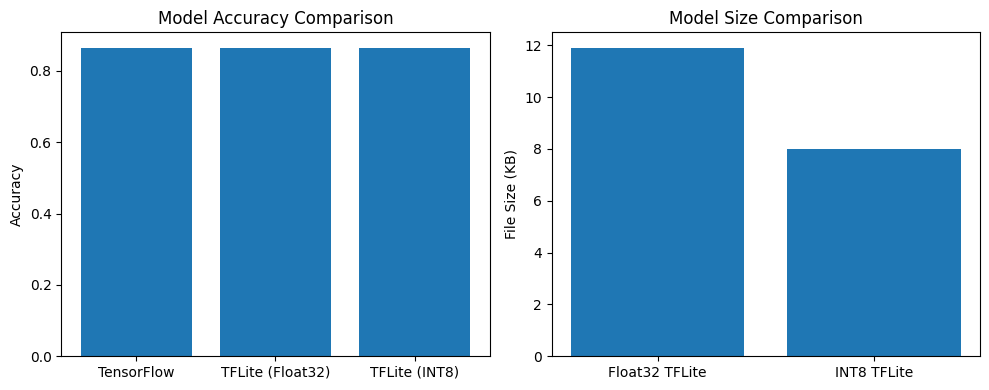

In [32]:
baseline_acc = score_model[1]
float32_acc = evaluate_tflite_model("model.tflite", x_test, y_test)
int8_acc = evaluate_tflite_model("model_int8.tflite", x_test, y_test)

float32_size = get_file_size("model.tflite")
int8_size = get_file_size("model_int8.tflite")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(['TensorFlow', 'TFLite (Float32)', 'TFLite (INT8)'],
        [baseline_acc, float32_acc, int8_acc])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

plt.subplot(1,2,2)
plt.bar(['Float32 TFLite', 'INT8 TFLite'], [float32_size, int8_size])
plt.ylabel('File Size (KB)')
plt.title('Model Size Comparison')

plt.tight_layout()
plt.show()


# Lab 3: Deployment

Now, that you have designed and trained a quantized model, it is time to deploy it.

### Model Export - Library Creation

Up until now we created different models that we can test and evaluate using Python. However, most microcontrollers don't speak Python. Instead they work with C/C++ and thus we need a C(++) library of the models to execute it. Here you explore different ways to export your models to a C(++) library.

#### Manual conversion of the model

---
**Task 21:** Convert your best performing quantized model to a C++ library with the code below and explain the content of the two resulting files.

**Answer:** ...

---

In [33]:
!apt-get update && apt-get -qq install xxd

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,741 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [32.8 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,003 kB]
Get:13 http://sec

In [34]:
MODEL_TFLITE = 'model.tflite' #enter the name of your TFlite file uploaded to the folders section
MODEL_TFLITE_MICRO = 'model.cc' #update the name of your .cc file (This can be anything)
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [35]:
LIBRARY_NAME = 'gesture_model'
max_label_str_length = max([len(lbl) for lbl in labels]) + 1

model_str = f"alignas(16) const unsigned char {LIBRARY_NAME}[] = "
with open(MODEL_TFLITE_MICRO, 'r') as file:
    data = file.read();
    model_str += data[data.index("{"): len(data)].replace("unsigned", "const")

labels_str = f"const char available_classes[][{max_label_str_length}] = {{"
for i in range(0, len(labels)):
    if i != 0:
        labels_str += ", "
    labels_str += "\""+labels[i]+"\""
labels_str += "};"

output_str = f"#include \"{LIBRARY_NAME}.h\"\n"
output_str += labels_str + "\n"
output_str += "const int available_classes_num = "+str(len(labels)) +";\n"
output_str += model_str

with open(f"{LIBRARY_NAME}.cpp", "w") as file:
    file.write(output_str)

header_str = "#ifndef TENSORFLOW_LITE_MODEL_H_\n#define TENSORFLOW_LITE_MODEL_H_\n\n"
header_str += "// Classes that can be detected by the neural network\n"
header_str += f"extern const char available_classes[][{max_label_str_length}];\n"
header_str += "extern const int available_classes_num;\n\n"
header_str += "// Pre-trained netural network\n"
header_str += f"extern const unsigned char {LIBRARY_NAME}[];\n"
header_str += f"extern const int {LIBRARY_NAME}_len;\n\n"
header_str += "#endif /* TENSORFLOW_LITE_MODEL_H_ */"

with open(f"{LIBRARY_NAME}.h", "w") as file:
    file.write(header_str)


Next you will use your library in an Arduino program to (or if you prefer, in a Zephyr program) and execute the [inference on a microcontroller](https://ai.google.dev/edge/litert/microcontrollers/get_started). I strongly recommend you to use [this](https://docs.arduino.cc/tutorials/nano-33-ble-sense/get-started-with-machine-learning) Arduino example as a starting point to write the code. (If you prefer to use Zephyr, have a look at [this](https://docs.zephyrproject.org/latest/samples/modules/tflite-micro/hello_world/README.html#tflite-hello-world) repository.)

---
**Task 22:** Write an Arduino (or Zephyr) program that records and uses a movement as input, classifies the gesture and reports the result back to you through the serial interface. For this, please do not forget to spend some time in the tutorials linked in the text block above.

**Task 23:** Upload the program to the Arduino and compare the real memory usage with the Edge Impulse estimate. Was the estimate correct? How much does it differ?

**Answer:** ...

**Task 24:** Extend your Arduino program and measure the inference time on the Arduino. Was the estimate correct?

**Answer:** ...

**Task 25:** Perform inference for at least 20 gestures and plot statistics (e.g., bar plot (mean) with error bar (standard deviation)) for the inference time. Does it vary? Why or why not?

**Answer:** ...



---

### Model conversion and library creation with Edge Impulse

In the last lab, you trained a model with Edge Impulse. Now we want to continue with that model and compare its on-device performance with your locally trained model.

---
**Task 26:** Head to your dashboard of the project of lab 1 and download the quantized models of your classifiers. Head to [https://netron.app/](https://netron.app/) and open your models with it. Click on the input or output layer and take a look at the quantization equations. Are the quantization equations the same for each of your classifiers? Why (not)?

**Answer:** ...

**Task 27:** Build two Arduino Libraries for your best performing model – one with enabling the EON Compiler and one without. (You might have to create an impulse containing only a single model.) For both libraries, use the quantized version. What is the EON Compiler, and why is the memory usage so different between the two libraries? Compare the models included in the two libraries (in `src > tflite-model`). How do they differ? What makes one of them smaller?

**Answer:** ...

**Task 28:** Include the libraries into your Arduino IDE (`Add .ZIP Library...`). Open the accelerometer example that comes with your library and flash it to your board. Open a serial monitor. Explain the Arduino program and the output of the serial monitor. Also, why is there a reference to numpy in the Arduino program? How is that possible in C++? Evaluate how well and how fast the classification works for each of your motions. Is there a difference in performance between the two Arduino libraries?

**Answer:** ...

**Task 29:** Compare the memory usage and performance of the two Edge Impulse models with your locally trained model. How do they compare? Please create plots.

**Answer:** ...

**Task 30 (optional):** You can also create an Arduino library with your locally trained model. Explore how to use Edge Impulse to [create a library](https://docs.edgeimpulse.com/docs/tools/edge-impulse-python-sdk) to deploy your local model. First, check the available target devices for deployment (`ei.model.list_deployment_targets()`) and find the correct Arduino corresponding to your hardware. Create an Arduino Library with Edge Impulse and compare its performance with the libraries above.

---